In [1]:
# Data manipulation and math computation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing

# Data visualisation 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import networkx as nx 
%matplotlib inline

# For statistical analysis
from scipy import stats

# Searchign for Outliers
from sklearn.ensemble import IsolationForest

# Metrics used for measuring the accuracy and performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV

# ML algorithms for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# ML algorithms for the classification
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

Using TensorFlow backend.


# Load the data

In [2]:
# Initial train dataset to be used as a baseline
pure_train_df = pd.read_csv("train.csv",sep=",")
# features and labels
pure_train_y = pure_train_df['Choice']
pure_train_x = pure_train_df.drop(columns=['Choice'])
print(pure_train_df.shape)
pure_train_df.head()

(5500, 23)


,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


In [12]:
# dataset after the graph analysis
network_train_df = pd.read_csv('PartitionedNetwork.csv',sep=",")
# Setup indexing
network_train_df.index = network_train_df['Unnamed: 0']
network_train_df.index.name = ''
# and drop the corresponding column
network_train_df.drop(columns=['Unnamed: 0'],inplace=True)
# features and labels
network_train_y = network_train_df['Choice']
network_train_x = network_train_df.drop(columns=['Choice'])
print(network_train_df.shape)
network_train_df.head()

(5319, 37)


,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,A_community,B_community,A_L_community,A_M_community,A_S_community,A_XS_community,B_L_community,B_M_community,B_S_community,B_XS_community
,,,,,,,,,,,,,,,,,,,,,
0,34,0,40,190,228,302,3,0.583979,0.100503,0.100503,...,0,1,1,0,0,0,0,1,0,0
1,33,1,39,113,21591,1179,228,90.456506,25.798292,5.709329,...,2,2,1,0,0,0,1,0,0,0
2,3,2,1,788,7310,1215,101,25.503644,9.556347,5.361519,...,3,3,0,0,1,0,0,0,1,0
3,39,3,38,99,20,7,2,7.690824,0.277306,1.331508,...,4,4,1,0,0,0,1,0,0,0
4,37,4,42,307,45589,862,2641,148.854279,36.998884,27.881768,...,4,4,1,0,0,0,1,0,0,0


# Define the models

## Functions to evaluate

In [9]:
# Function to evaluate the results using Accuracy and ROC AUC
def evaluate(model,x_test,y_true):
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    #Accuracy score 
    accuracy = accuracy_score(y_pred=predictions,y_true=y_true)
    print("\nAccuracy: {:.3f}% ".format(accuracy*100))
    # ROC AUC score
    roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y_true)
    print("ROC AUC: {:.3f}% \n".format(roc_auc*100))  

# Run cross-validation
def run_cross_validation(model,name,x_tot,y_tot,cv):
    print('Starting Cross-validation')
    
    #Score using accuracy
    scoresAccuracy=cross_val_score(model,x_tot,y_tot,cv=cv,verbose=1)
    print("CV with accuracy: %0.3f +/- %0.3f" % (scoresAccuracy.mean(), scoresAccuracy.std()))
    
    #Score with AUC
    scoresROCAUC=cross_val_score(model,x_tot,y_tot,cv=cv,scoring='roc_auc',verbose=1)
    print("CV with ROC AUC: %0.3f +/- %0.3f" % (scoresROCAUC.mean(), scoresROCAUC.std()))
    
    #Plot learning curve 
    plot_learning_curve(model,name,x_tot,y_tot,cv=cv,n_jobs=-1)
    plt.show()
    
def advanced_evaluate_model(model,name, x_train, y_train, x_test, y_test, cv):
    # Train the algorithm
    history = model.fit(x_train,y_train)
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    print(model)
    # Evaluate the results
    evaluate(model,x_test,y_test) 
    
    # Merge test and train samples
    x_tot = pd.concat([x_train,x_test],axis=0)
    y_tot = pd.concat([y_train,y_test],axis=0)

    # If run cross-validation:
    if cv:
        #Cross-validation

        # Splitting strategy
        kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
    
        run_cross_validation(model,name,x_tot,y_tot,cv=kfold)
    
    # ROC Curve. 
    fpr,tpr,thresh = roc_curve(y_test,predicting_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr,tpr,label = ("Area under the curve {:0.3f}".format(auc(fpr,tpr))),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title(name + " ROC - Curve & Area Under Curve",fontsize=18)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
    # plot learning history:
    if name == 'DNN': 
        plot_DNN_training_history(history)
        plt.show()
    
    print('\n\n')
    
    model.fit(x_tot,y_tot)
    
    return model

# function to evaluate the feature importance
def feature_importance(df_ini,model,model_type,model_name):
    # transform the input data, accessing is different for different algorithms, hard coded now. 
    # Should be imporved later
    if model_type == 'importance':
        df = pd.DataFrame(model.feature_importances_,df_ini.columns).reset_index()
    else:
        df = pd.DataFrame(model.coef_.ravel(),df_ini.columns).reset_index()
    df.rename(columns={'index':'features',0:'coefficients'},inplace=True)
    # sort the values
    df.sort_values(by='coefficients',ascending = False,inplace=True)
        
    #plot
    sns.barplot(x = df['coefficients'] ,y = df['features'])    
    plt.title("Feature Importance " + model_name,fontsize=11,fontweight="bold")
    
def fast_feature_importance(df,models):
    df_x = df
    if 'Choice' in df.columns:
        df_x = df.drop(columns=['Choice'])
    # Analyse feature importance
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)
    for i, model in enumerate(models,start=1):
        plt.subplot(2,2,i)
        feature_importance(df_x,model.model,model.model_type,model.name)
        
# function from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## ML models

In [4]:
class MLmodel:
    def __init__(self,model,name,model_type = 'importance'):
        self.name = name
        self.model = model
        self.model_type = model_type

In [72]:
models = [
    XGBClassifier(random_state=1,n_estimators=1000,learning_rate=0.01,max_depth=3),
    LogisticRegression(penalty='l1',class_weight='balanced', random_state=1),
    RandomForestClassifier(n_estimators=100,random_state=1,max_depth=3,min_samples_leaf=10),
]

MLmodels = [
    MLmodel(models[0],'XGBoost','importance'),
    MLmodel(models[1],'LogisticRegression','coef'),
    MLmodel(models[2],'RandomForest','importance')
]

# Baseline

## Pure dataset

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 76.273% 
ROC AUC: 86.069% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   51.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.783 +/- 0.011
CV with ROC AUC: 0.873 +/- 0.013


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   50.1s finished


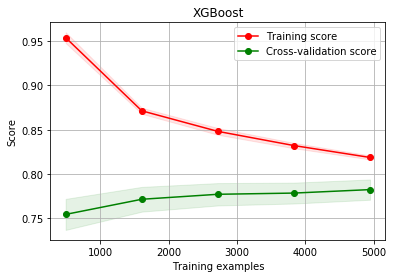

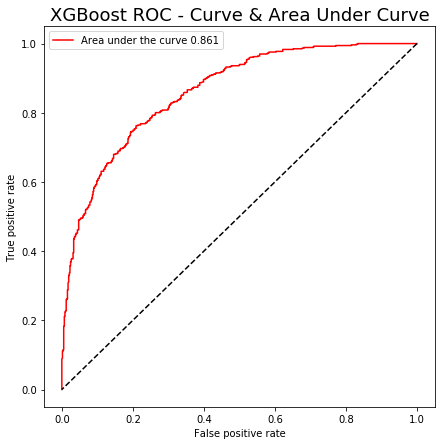




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 71.364% 
ROC AUC: 77.278% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.735 +/- 0.018


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.3s finished


CV with ROC AUC: 0.798 +/- 0.014


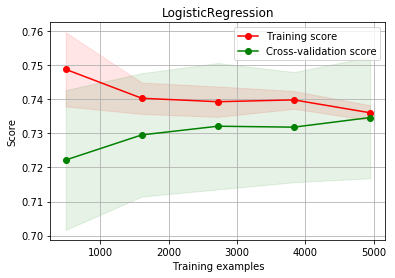

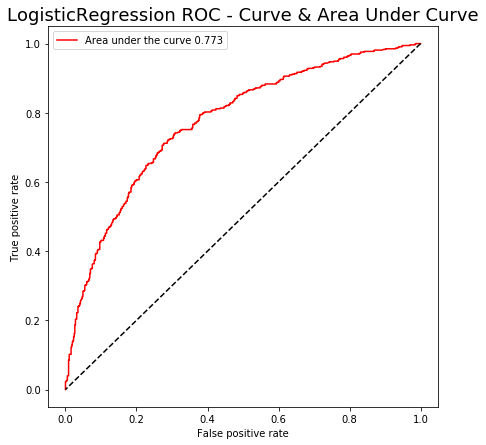




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 74.636% 
ROC AUC: 84.083% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.768 +/- 0.015


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.1s finished


CV with ROC AUC: 0.855 +/- 0.015


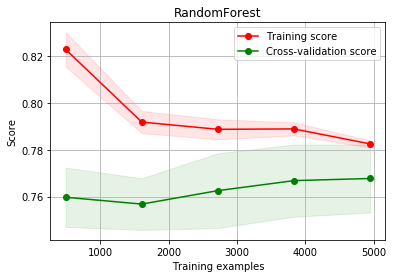

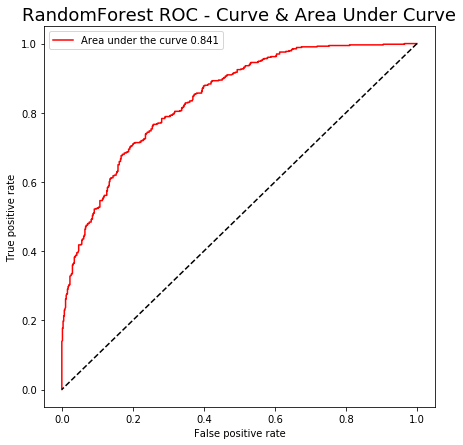

In [10]:
model_res = {}
x_train, x_test, y_train, y_test = train_test_split(pure_train_x, pure_train_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

## Network dataset 

* First run with all the columns, just to test

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 78.289% 
ROC AUC: 87.679% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.777 +/- 0.018
CV with ROC AUC: 0.871 +/- 0.016


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.1min finished


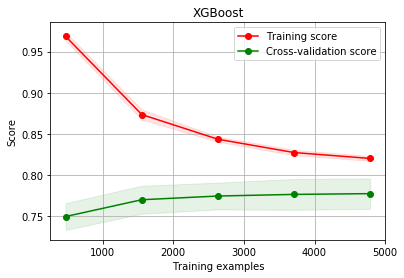

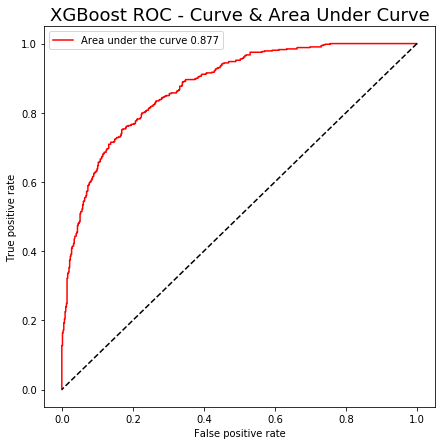




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 72.932% 
ROC AUC: 79.203% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.724 +/- 0.019


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.0s finished


CV with ROC AUC: 0.795 +/- 0.017


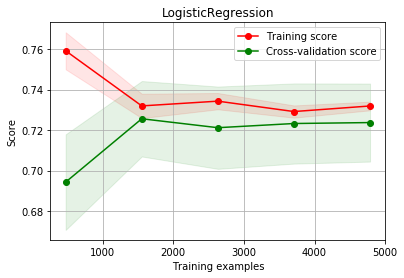

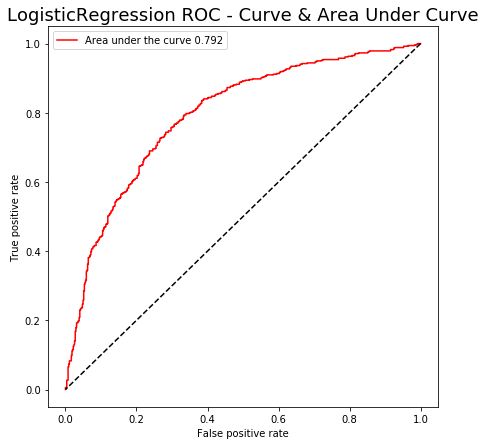




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 76.786% 
ROC AUC: 86.180% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.763 +/- 0.021


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.5s finished


CV with ROC AUC: 0.853 +/- 0.018


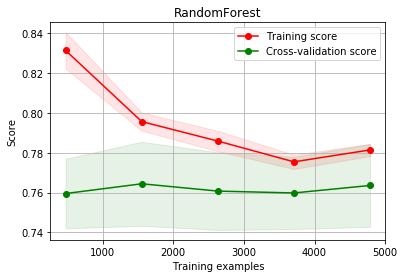

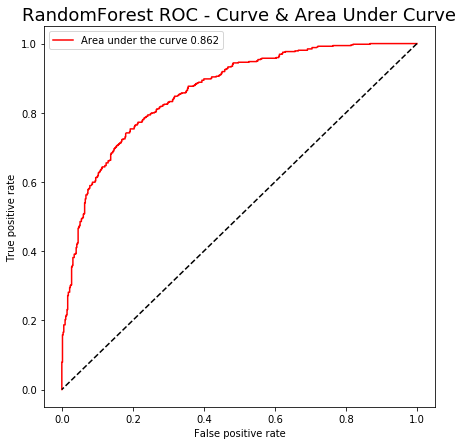

In [13]:
x_train, x_test, y_train, y_test = train_test_split(network_train_x, network_train_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

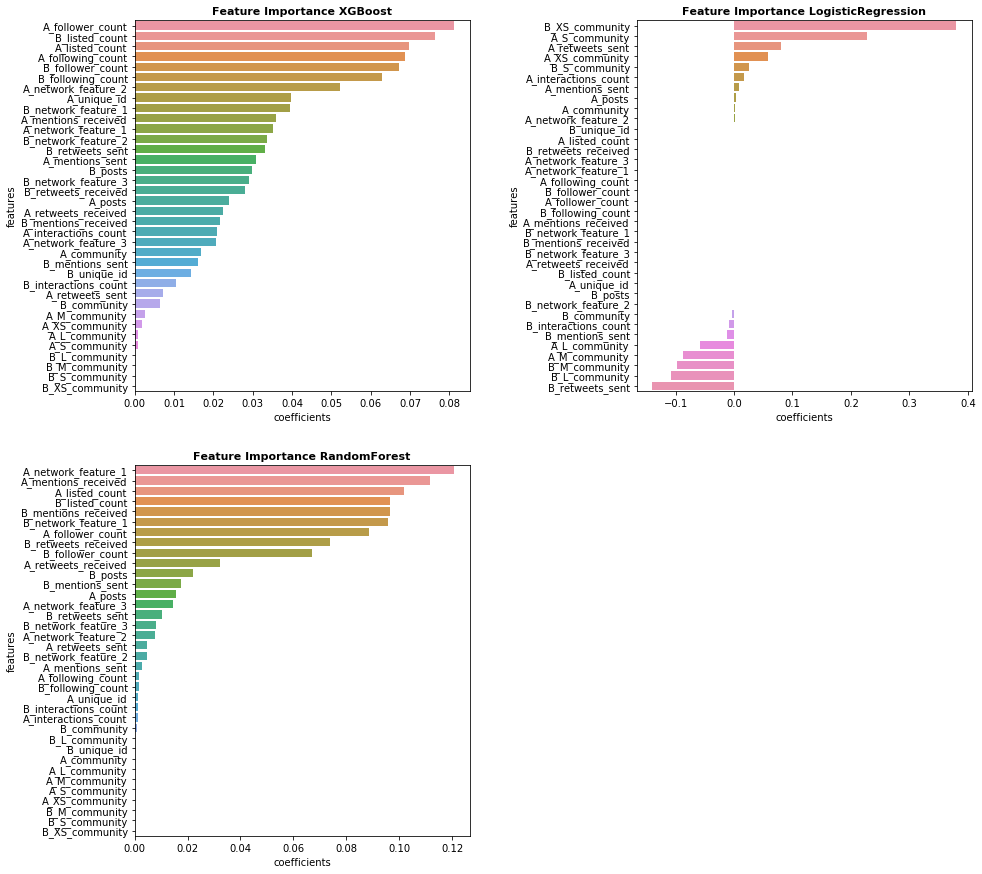

In [14]:
fast_feature_importance(network_train_x,MLmodels)

* Improvement of 1.5% for the XGBoost and 2% for the RF on the validation data. No improvement in the cross-validation scores.
* Drop some columns

In [15]:
network_train_x.head()

,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,A_community,B_community,A_L_community,A_M_community,A_S_community,A_XS_community,B_L_community,B_M_community,B_S_community,B_XS_community
,,,,,,,,,,,,,,,,,,,,,
0,34,0,40,190,228,302,3,0.583979,0.100503,0.100503,...,0,1,1,0,0,0,0,1,0,0
1,33,1,39,113,21591,1179,228,90.456506,25.798292,5.709329,...,2,2,1,0,0,0,1,0,0,0
2,3,2,1,788,7310,1215,101,25.503644,9.556347,5.361519,...,3,3,0,0,1,0,0,0,1,0
3,39,3,38,99,20,7,2,7.690824,0.277306,1.331508,...,4,4,1,0,0,0,1,0,0,0
4,37,4,42,307,45589,862,2641,148.854279,36.998884,27.881768,...,4,4,1,0,0,0,1,0,0,0


In [16]:
network_train_reduced_x = network_train_x.drop(columns=['B_unique_id','A_unique_id','A_community','B_community'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 77.538% 
ROC AUC: 87.696% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.778 +/- 0.016


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.0min finished


CV with ROC AUC: 0.871 +/- 0.016


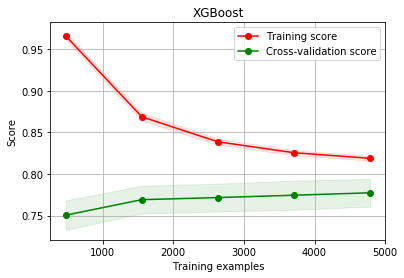

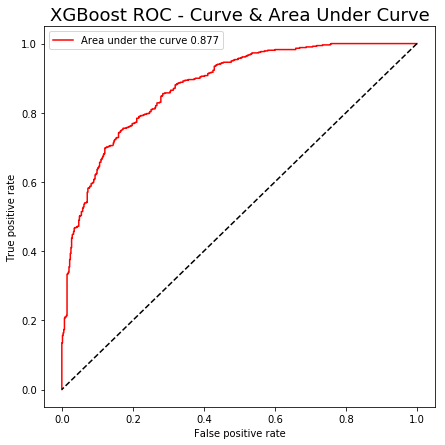




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 72.932% 
ROC AUC: 79.152% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.725 +/- 0.019


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished


CV with ROC AUC: 0.796 +/- 0.016


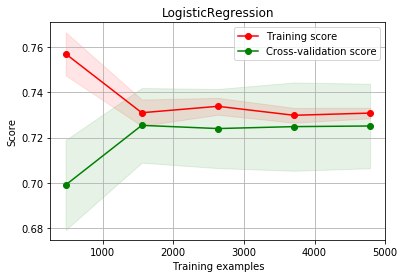

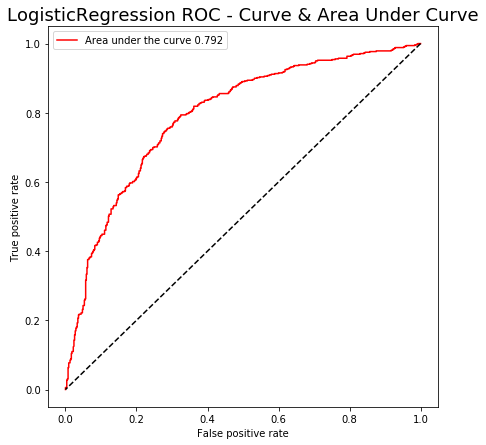




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 76.316% 
ROC AUC: 86.065% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.763 +/- 0.017


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished


CV with ROC AUC: 0.853 +/- 0.018


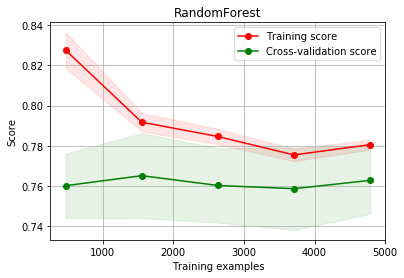

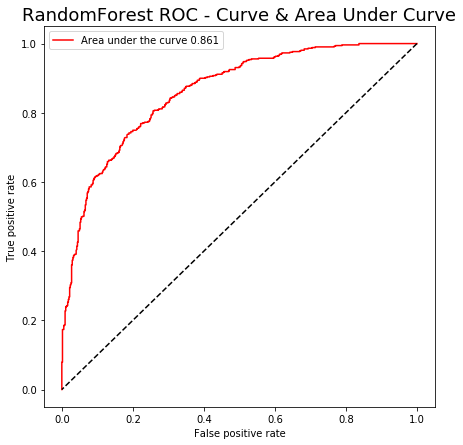

In [17]:
x_train, x_test, y_train, y_test = train_test_split(network_train_reduced_x, network_train_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

# Train models for communities

In [19]:
study_comm_df = network_train_df.copy()
study_comm_df.head()

,B_interactions_count,B_unique_id,A_interactions_count,A_unique_id,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,...,A_community,B_community,A_L_community,A_M_community,A_S_community,A_XS_community,B_L_community,B_M_community,B_S_community,B_XS_community
,,,,,,,,,,,,,,,,,,,,,
0,34,0,40,190,228,302,3,0.583979,0.100503,0.100503,...,0,1,1,0,0,0,0,1,0,0
1,33,1,39,113,21591,1179,228,90.456506,25.798292,5.709329,...,2,2,1,0,0,0,1,0,0,0
2,3,2,1,788,7310,1215,101,25.503644,9.556347,5.361519,...,3,3,0,0,1,0,0,0,1,0
3,39,3,38,99,20,7,2,7.690824,0.277306,1.331508,...,4,4,1,0,0,0,1,0,0,0
4,37,4,42,307,45589,862,2641,148.854279,36.998884,27.881768,...,4,4,1,0,0,0,1,0,0,0


In [70]:
#sanity check:
msum = 0
network_train_comm_df = dict()
network_train_comm_y = dict()
network_train_comm_x = dict()
for s in ['L','M','S','XS','nL']:
    if s == 'nL':
        network_train_comm_df[s] = study_comm_df.query('A_L_community != 1 or B_L_community != 1')
    else:
        msum += study_comm_df.query('A_' + s + '_community == 1 and B_' + s + '_community == 1').shape[0]
        network_train_comm_df[s] = study_comm_df.query('A_' + s + '_community == 1 and B_' + s + '_community == 1')
    network_train_comm_y[s] = network_train_comm_df[s]['Choice']
    network_train_comm_x[s] = network_train_comm_df[s].drop(columns=['Choice'])
    print('Size of community ' + s + ': ' + str(network_train_comm_x[s].shape[0]))
    # Save to CSV file for PCA
    network_train_comm_df[s].to_csv('Community_' + s + '.csv')
msum

Size of community L: 4105
Size of community M: 206
Size of community S: 232
Size of community XS: 252
Size of community nL: 1214


4795

* Check the balance:

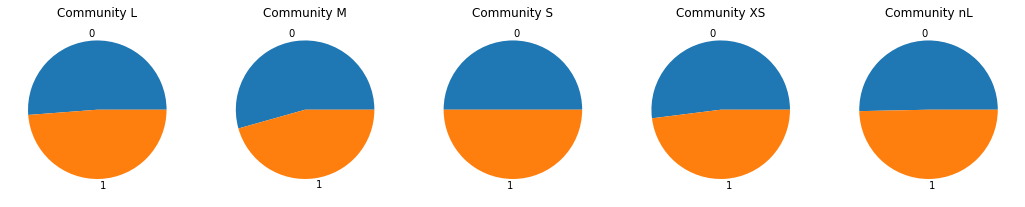

In [60]:
# function to check for data imbalance
def plot_data_balance(df,title):
#    plt.figure(figsize=(12,6))
    plt.pie(df["Choice"].value_counts().values,labels=["0","1"])
    plt.title(title)

plt.figure(figsize=(18,18))
for i,s in enumerate(['L','M','S','XS','nL'],start=1):
    plt.subplot(1,5,i)
    plot_data_balance(network_train_comm_df[s],'Community ' + s)

* Drop all the community related columns

In [41]:
to_drop = [user + '_' + s + '_community' for user in ['A','B'] for s in ['L','M','S','XS']]
to_drop += ['A_community','B_community','A_unique_id','B_unique_id']
print(to_drop)

['A_L_community', 'A_M_community', 'A_S_community', 'A_XS_community', 'B_L_community', 'B_M_community', 'B_S_community', 'B_XS_community', 'A_community', 'B_community', 'A_unique_id', 'B_unique_id']


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 80.999% 
ROC AUC: 89.923% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   36.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.793 +/- 0.024
CV with ROC AUC: 0.888 +/- 0.016


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   36.9s finished


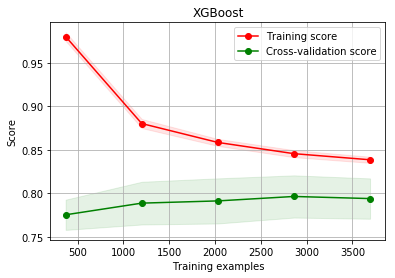

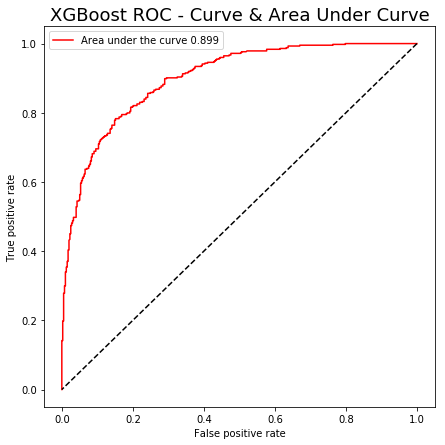




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 76.492% 
ROC AUC: 83.096% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.744 +/- 0.031


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.9s finished


CV with ROC AUC: 0.816 +/- 0.027


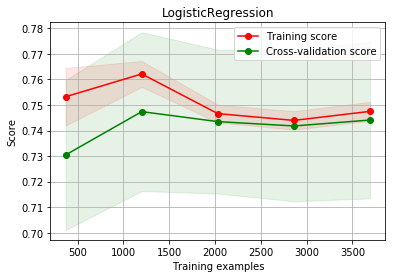

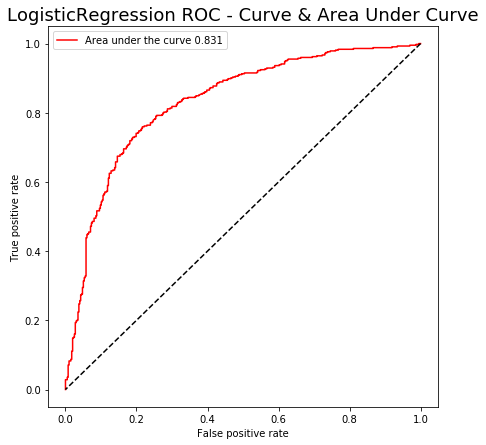




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 78.928% 
ROC AUC: 87.993% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.782 +/- 0.026


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished


CV with ROC AUC: 0.873 +/- 0.019


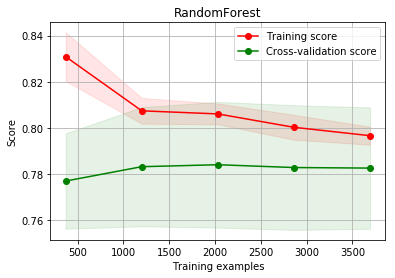

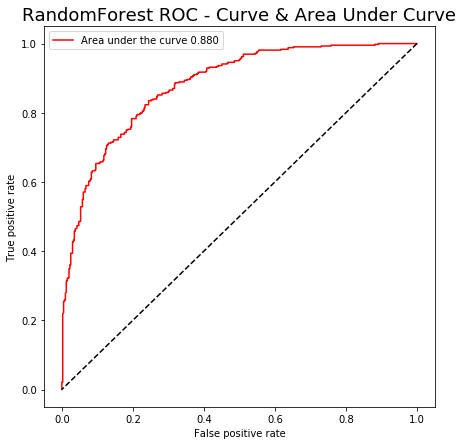

In [61]:
# Check the largest communities
x_train, x_test, y_train, y_test = train_test_split(network_train_comm_x['L'].drop(columns=to_drop), network_train_comm_y['L'], test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 76.471% 
ROC AUC: 85.494% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.669 +/- 0.102


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished


CV with ROC AUC: 0.723 +/- 0.125


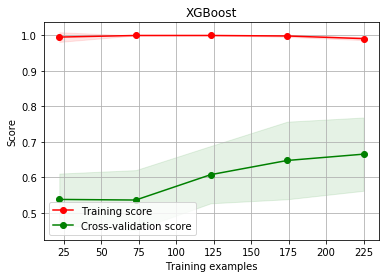

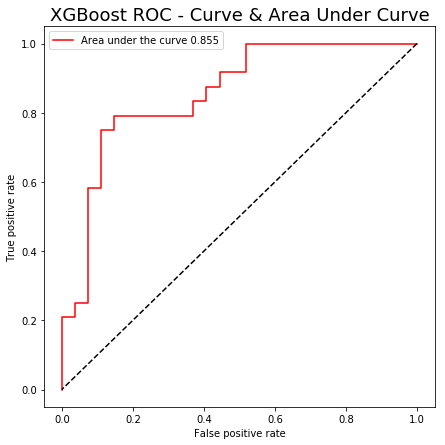




LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 74.510% 
ROC AUC: 75.926% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.607 +/- 0.087


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


CV with ROC AUC: 0.668 +/- 0.087


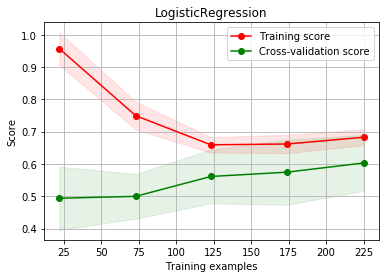

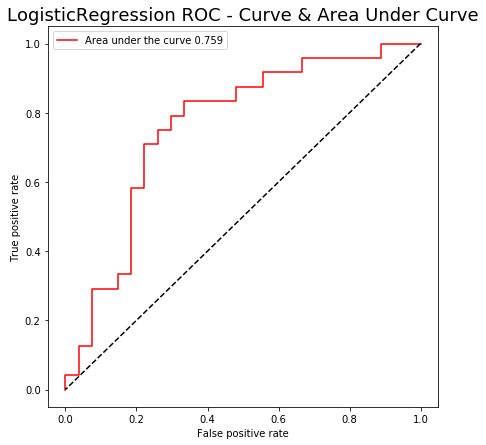




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 74.510% 
ROC AUC: 82.407% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.617 +/- 0.111


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.4s finished


CV with ROC AUC: 0.700 +/- 0.107


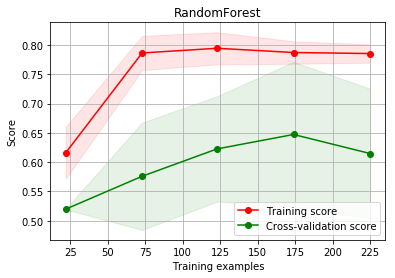

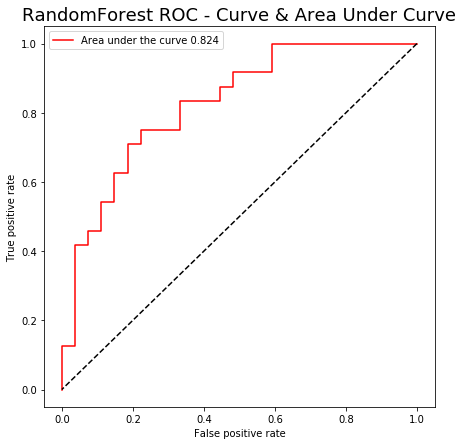

In [73]:
# Check !large
x_train, x_test, y_train, y_test = train_test_split(network_train_comm_x['XS'].drop(columns=to_drop), network_train_comm_y['XS'], test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Accuracy: 74.510% 
ROC AUC: 77.006% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.653 +/- 0.100


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.0s finished


CV with ROC AUC: 0.698 +/- 0.114


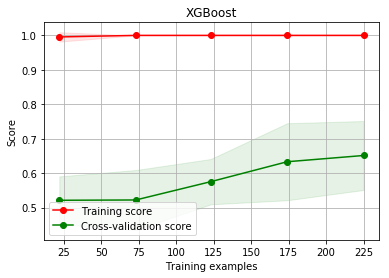

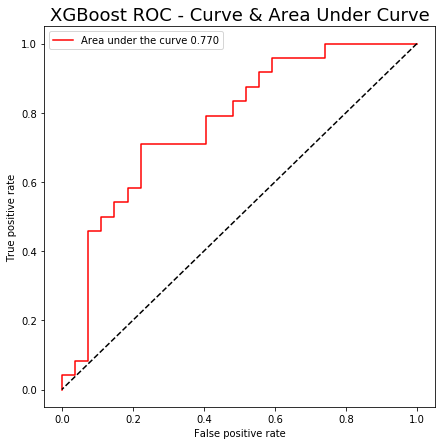




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Accuracy: 70.588% 
ROC AUC: 81.944% 

Starting Cross-validation


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV with accuracy: 0.625 +/- 0.125


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.8s finished


CV with ROC AUC: 0.709 +/- 0.118


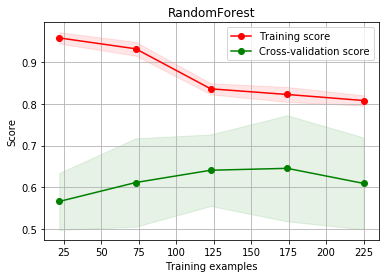

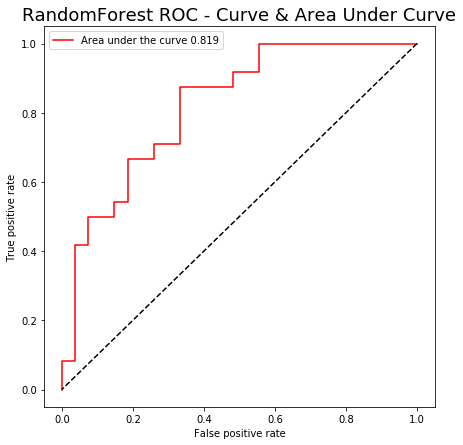

In [69]:
# Trying to overfit 
models = [
    XGBClassifier(random_state=1,n_estimators=1000,learning_rate=0.02,max_depth=10,),
    RandomForestClassifier(n_estimators=200,random_state=1,max_depth=3,min_samples_leaf=2),
]

MLmodels = [
    MLmodel(models[0],'XGBoost','importance'),
    MLmodel(models[1],'RandomForest','importance')
]

x_train, x_test, y_train, y_test = train_test_split(network_train_comm_x['XS'].drop(columns=to_drop), network_train_comm_y['XS'], test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)